In [1]:
import sys
sys.path.append("/fp/homes01/u01/ec-krimhau/.local/lib/python3.11/site-packages")

In [2]:
from codecarbon import EmissionsTracker
import logging
output_directory = "/fp/homes01/u01/ec-krimhau/thesis_code/"

tracker = EmissionsTracker(output_dir=output_directory)
tracker.start()

[codecarbon INFO @ 11:31:47] [setup] RAM Tracking...
[codecarbon INFO @ 11:31:47] [setup] GPU Tracking...
[codecarbon INFO @ 11:31:47] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 11:31:47] [setup] CPU Tracking...
[codecarbon WARNING @ 11:31:47] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 11:31:50] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 11:31:50] CPU Model on constant consumption mode: AMD EPYC 7642 48-Core Processor
[codecarbon INFO @ 11:31:50] >>> Tracker's metadata:
[codecarbon INFO @ 11:31:50]   Platform system: Linux-5.14.0-362.8.1.el9_3.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 11:31:50]   Python version: 3.11.3
[codecarbon INFO @ 11:31:50]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 11:31:50]   Available RAM : 256.000 GB
[codecarbon INFO @ 11:31:50]   CPU count: 24
[codecarbon INFO @ 11:31:50]   CPU model: AMD EPYC 7642 48-Core Processor
[codecarbon 

In [3]:
logging.getLogger('codecarbon').setLevel(logging.WARNING)

In [4]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

import wandb
# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
# Load .env file
%load_ext dotenv
%dotenv /fp/homes01/u01/ec-krimhau/thesis_code/.env

In [6]:
# Get wandb api key from .env file
wandb_api_key = os.getenv('WANDB_API_KEY')
# Login to wandb to track results
wandb.login(key = wandb_api_key) # API key

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: haugerud-kristian (krimhau). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /fp/homes01/u01/ec-krimhau/.netrc


True

In [7]:
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))


HASH_NAME = id_generator(size=12)
print(HASH_NAME)


toqqhtqywyqr


In [8]:
CONFIG = {"seed": 42,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


In [9]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [10]:
def train_test_split(df, train_percent=.85, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [11]:
import pandas as pd
path_to_files = "/fp/projects01/ec307/ec-krimhau/github_datasets/HP_vs_med_low"
file_name = "high_vs_med_low_top_50_hp_repos_balanced_github.csv"
full_training_df = pd.read_csv(f"{path_to_files}/{file_name}")
full_training_df

,label,text
0,0,speed up asymmetry calculation this issue was ...
1,0,with pgleaderchangewaitqueuestestaddtwoservers...
2,1,healthcareapiclientfhirfhirresourcestest testc...
3,0,on there is a core seen within less than an ho...
4,0,capture and send the submitter button when sub...
...,...,...
42625,0,add preview button to the form for creating ne...
42626,0,ecommerce customers menu item visibility quick...
42627,1,could not add relations i could not add a new ...
42628,0,deleting a profile does not remove the instanc...


In [12]:
full_training_df

,label,text
0,0,speed up asymmetry calculation this issue was ...
1,0,with pgleaderchangewaitqueuestestaddtwoservers...
2,1,healthcareapiclientfhirfhirresourcestest testc...
3,0,on there is a core seen within less than an ho...
4,0,capture and send the submitter button when sub...
...,...,...
42625,0,add preview button to the form for creating ne...
42626,0,ecommerce customers menu item visibility quick...
42627,1,could not add relations i could not add a new ...
42628,0,deleting a profile does not remove the instanc...


In [13]:
!ls ../../csv

highest_vs_rest_balanced_jira.csv
jira_highest_vs_rest_clean_Jira_balanced.csv
jira_highest_vs_rest_clean_MongoDB_balanced.csv
jira_highest_vs_rest_clean_MongoDB_balanced.csv_70_Test_inference.csv
jira_highest_vs_rest_clean_Qt_balanced.csv
jira_highest_vs_rest_clean_Qt_balanced.csv_70_Test_inference.csv


In [14]:
project_name  = "Jira"
file_name = f"../../csv/jira_highest_vs_rest_clean_{project_name}_balanced.csv"

In [15]:
import pandas as pd
fine_tuning_df = pd.read_csv(file_name)
fine_tuning_df

,text_clean,label
0,using firefox on ubuntu and seeing the same th...,0
1,summary when using bitbucket cloud as a reposi...,0
2,we have identified and fixed a crosssite scrip...,1
3,note this bug is for jira server using jira cl...,0
4,problem definition on the old issue view hover...,0
...,...,...
9327,issue summary when jira and confluence are con...,0
9328,clover database contains fileinfo objects for ...,0
9329,lwjdemacbookpro lwj ping bitbucketorgping bitb...,0
9330,definition all of a sudden some users are unab...,1


In [16]:
fine_tuning_df = fine_tuning_df.rename(columns={'text_clean': 'text'})
fine_tuning_df

,text,label
0,using firefox on ubuntu and seeing the same th...,0
1,summary when using bitbucket cloud as a reposi...,0
2,we have identified and fixed a crosssite scrip...,1
3,note this bug is for jira server using jira cl...,0
4,problem definition on the old issue view hover...,0
...,...,...
9327,issue summary when jira and confluence are con...,0
9328,clover database contains fileinfo objects for ...,0
9329,lwjdemacbookpro lwj ping bitbucketorgping bitb...,0
9330,definition all of a sudden some users are unab...,1


In [17]:
# Split the full training dataframe into training and test dataframes
# 85/15 split. Validation set will be created from the training set later.
train_full_training_df, test_full_training_df = train_test_split(full_training_df)


In [18]:
# Split the fine-tuning data frame into training and test data frames
# Where 30% of the data is used for training and 70% for testing
fine_tune_train_df , fine_tune_test_df = train_test_split(fine_tuning_df, train_percent=.30) # 30%

In [19]:
fine_tune_train_df

,text,label
6405,it was reported as before reported as resolved...,1
6984,error there was an error loading the descripto...,0
2111,project portlets do not respect categories on ...,1
5516,have a bunch of issue that add up to turn on q...,1
6657,issue summary when restoring the index from an...,0
...,...,...
6324,in the review suggestions dialog the table lis...,0
1515,i believe your service incorrectly computed th...,1
216,note this bug report is for jira service desk ...,1
8446,the view email link is generated using the ema...,1


In [20]:
# Concatenate the training dataframes into the final training dataframe
df = pd.concat([train_full_training_df, fine_tune_train_df], ignore_index = True)

In [21]:
df

,label,text
0,0,use correct case for help documentation in eg ...
1,0,overwriting bookmark folders when syncing devi...
2,0,no results if country is specified in the quer...
3,0,prepopulate subject of message when clicking r...
4,0,timeout on wiki listoffeaturedimages does not ...
...,...,...
39029,0,in the review suggestions dialog the table lis...
39030,1,i believe your service incorrectly computed th...
39031,1,note this bug report is for jira service desk ...
39032,1,the view email link is generated using the ema...


In [22]:
gkf = GroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(gkf.split(X=df, groups=df.text)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)


In [23]:
df.groupby('kfold')['label'].value_counts()


kfold  label
0      1        6520
       0        6492
1      0        6573
       1        6438
2      1        6550
       0        6461
Name: count, dtype: int64

In [24]:
df

,label,text,kfold
0,0,use correct case for help documentation in eg ...,2
1,0,overwriting bookmark folders when syncing devi...,0
2,0,no results if country is specified in the quer...,0
3,0,prepopulate subject of message when clicking r...,2
4,0,timeout on wiki listoffeaturedimages does not ...,2
...,...,...,...
39029,0,in the review suggestions dialog the table lis...,2
39030,1,i believe your service incorrectly computed th...,0
39031,1,note this bug report is for jira service desk ...,2
39032,1,the view email link is generated using the ema...,2


In [25]:
class HP_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        self.targets = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'target': self.targets[index]
        }

In [26]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])


In [27]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [28]:
class HP_Model(nn.Module):
    def __init__(self, model_name):
        super(HP_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [29]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [30]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score



In [32]:
def all_classification_report(y_true, y_pred, target_names = ['Non_HP', 'HP'], digits=4):
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names = target_names, digits=4))
    
    accuracy =round(accuracy_score(y_true, y_pred),4)
    print("Accuracy =",  accuracy)
    f1score = round(f1_score(y_true, y_pred),4)
    print("F1_score =", f1score)

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Non_HP', 'HP'])
    ax.yaxis.set_ticklabels(['Non_HP', 'HP'])
    
    return  accuracy , f1score
    
    

In [33]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    
    y_pred = []
    y_true = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        

        predictions = torch.argmax(outputs, dim=-1).flatten().tolist()
        
        target = targets.tolist()

        y_pred.extend(predictions)
        y_true.extend(target)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])   
    
    
    accuracy, f1score = all_classification_report(y_true,y_pred)
    gc.collect()
    
    return epoch_loss , accuracy , f1score

In [34]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, accuracy , f1score = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
      
        history['Valid accuracy'].append(accuracy)
        history['Valid f1score'].append(f1score)



        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid Accuracy": accuracy})
        wandb.log({"Valid F1_score": f1score})


        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{HASH_NAME}-Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


In [35]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = HP_Dataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = HP_Dataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [36]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

====== Fold: 0 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 814/814 [02:10<00:00,  6.21it/s, Epoch=1, LR=5.44e-6, Valid_Loss=0.51] 


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7119    0.8279    0.7656      6492
          HP     0.7955    0.6664    0.7253      6520

    accuracy                         0.7470     13012
   macro avg     0.7537    0.7472    0.7454     13012
weighted avg     0.7538    0.7470    0.7454     13012

Accuracy = 0.747
F1_score = 0.7253
Validation Loss Improved (inf ---> 0.5104635694083381)
Model Saved



100%|██████████| 814/814 [02:10<00:00,  6.22it/s, Epoch=2, LR=1e-6, Valid_Loss=0.479]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7186    0.8606    0.7832      6492
          HP     0.8272    0.6644    0.7369      6520

    accuracy                         0.7623     13012
   macro avg     0.7729    0.7625    0.7601     13012
weighted avg     0.7730    0.7623    0.7600     13012

Accuracy = 0.7623
F1_score = 0.7369
Validation Loss Improved (0.5104635694083381 ---> 0.47938070374564173)
Model Saved



100%|██████████| 814/814 [02:10<00:00,  6.22it/s, Epoch=3, LR=5.67e-6, Valid_Loss=0.487]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7465    0.8273    0.7848      6492
          HP     0.8073    0.7202    0.7613      6520

    accuracy                         0.7737     13012
   macro avg     0.7769    0.7738    0.7731     13012
weighted avg     0.7770    0.7737    0.7730     13012

Accuracy = 0.7737
F1_score = 0.7613

Training complete in 0h 50m 35s
Best Loss: 0.4794


Train Loss,█▃▁
Valid Accuracy,▁▅█
Valid F1_score,▁▃█
Valid Loss,█▁▃
Best Loss,0.47938
Train Loss,0.42162
Valid Accuracy,0.7737
Valid F1_score,0.7613
Valid Loss,0.48714



====== Fold: 1 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 814/814 [02:11<00:00,  6.19it/s, Epoch=1, LR=5.44e-6, Valid_Loss=0.508]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7079    0.8459    0.7708      6573
          HP     0.8036    0.6437    0.7148      6438

    accuracy                         0.7458     13011
   macro avg     0.7557    0.7448    0.7428     13011
weighted avg     0.7552    0.7458    0.7431     13011

Accuracy = 0.7458
F1_score = 0.7148
Validation Loss Improved (inf ---> 0.5084787840279176)
Model Saved



100%|██████████| 814/814 [02:11<00:00,  6.20it/s, Epoch=2, LR=1e-6, Valid_Loss=0.493]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7078    0.8829    0.7857      6573
          HP     0.8400    0.6278    0.7186      6438

    accuracy                         0.7567     13011
   macro avg     0.7739    0.7553    0.7521     13011
weighted avg     0.7732    0.7567    0.7525     13011

Accuracy = 0.7567
F1_score = 0.7186
Validation Loss Improved (0.5084787840279176 ---> 0.49291693036868306)
Model Saved



100%|██████████| 814/814 [02:11<00:00,  6.20it/s, Epoch=3, LR=5.67e-6, Valid_Loss=0.493]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7736    0.7726    0.7731      6573
          HP     0.7681    0.7692    0.7686      6438

    accuracy                         0.7709     13011
   macro avg     0.7709    0.7709    0.7709     13011
weighted avg     0.7709    0.7709    0.7709     13011

Accuracy = 0.7709
F1_score = 0.7686
Validation Loss Improved (0.49291693036868306 ---> 0.49285618606166004)
Model Saved

Training complete in 0h 50m 48s
Best Loss: 0.4929


Train Loss,█▃▁
Valid Accuracy,▁▄█
Valid F1_score,▁▁█
Valid Loss,█▁▁
Best Loss,0.49286
Train Loss,0.42378
Valid Accuracy,0.7709
Valid F1_score,0.7686
Valid Loss,0.49286



====== Fold: 2 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 814/814 [02:10<00:00,  6.22it/s, Epoch=1, LR=5.44e-6, Valid_Loss=0.693]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7576    0.0039    0.0077      6461
          HP     0.5041    0.9988    0.6700      6550

    accuracy                         0.5047     13011
   macro avg     0.6308    0.5013    0.3389     13011
weighted avg     0.6300    0.5047    0.3411     13011

Accuracy = 0.5047
F1_score = 0.67
Validation Loss Improved (inf ---> 0.6930252336427751)
Model Saved



100%|██████████| 814/814 [02:11<00:00,  6.21it/s, Epoch=2, LR=1e-6, Valid_Loss=0.632]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.5960    0.8393    0.6970      6461
          HP     0.7347    0.4388    0.5494      6550

    accuracy                         0.6377     13011
   macro avg     0.6653    0.6391    0.6232     13011
weighted avg     0.6658    0.6377    0.6227     13011

Accuracy = 0.6377
F1_score = 0.5494
Validation Loss Improved (0.6930252336427751 ---> 0.6317440975492075)
Model Saved



100%|██████████| 814/814 [02:11<00:00,  6.21it/s, Epoch=3, LR=5.67e-6, Valid_Loss=0.531]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7354    0.7169    0.7260      6461
          HP     0.7275    0.7455    0.7364      6550

    accuracy                         0.7313     13011
   macro avg     0.7314    0.7312    0.7312     13011
weighted avg     0.7314    0.7313    0.7312     13011

Accuracy = 0.7313
F1_score = 0.7364
Validation Loss Improved (0.6317440975492075 ---> 0.5309496952023095)
Model Saved

Training complete in 0h 50m 45s
Best Loss: 0.5309


Train Loss,██▁
Valid Accuracy,▁▅█
Valid F1_score,▆▁█
Valid Loss,█▅▁
Best Loss,0.53095
Train Loss,0.58437
Valid Accuracy,0.7313
Valid F1_score,0.7364
Valid Loss,0.53095


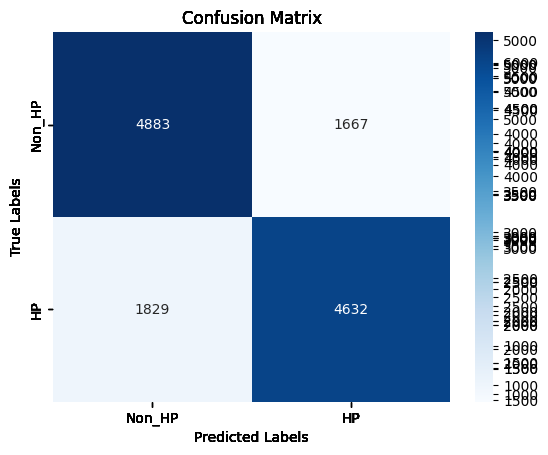

In [37]:
for fold in range(0, CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='HP_results_Jira_High_vs_rest_results', 
                     config=CONFIG,
                     job_type='Train',
                     group=CONFIG['group'],
                     tags=[CONFIG['model_name'], f'{HASH_NAME}'],
                     name=f'{HASH_NAME}-fold-{fold}',
                     anonymous='must')
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold)
    
    model = HP_Model(CONFIG['model_name'])
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    run.finish()
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

<h2> Testing Inference </h2>


In [38]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [39]:
test_df = fine_tune_test_df

In [40]:
test_df

,text,label
5273,since two weeks i have sometimes this message ...,1
6591,in wiki the links to issues in issue tracker a...,0
3706,when you select the root branch in the branch ...,0
893,entering more than characters in the applicati...,0
5937,trying to push to git i am getting this error ...,1
...,...,...
5734,note this bug report is for confluence cloud u...,1
5191,the updatingstatus action is vulnerable to sto...,1
5390,hiwhile trying to push my commits to repo i am...,1
860,users with no administrative permissions see a...,0


In [41]:
class HP_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [42]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = HP_Model(CONFIG['model_name'])

In [43]:
def prepare_test_loader(test_df):    
    test_dataset = HP_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [44]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [45]:
# Change the HASH_NAME according to new generated hash for your run
#HASH_NAME = "ekgx4wmexn91"


In [46]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|██████████| 409/409 [00:55<00:00,  7.43it/s]


Fold 1


100%|██████████| 409/409 [00:54<00:00,  7.44it/s]


Fold 2


100%|██████████| 409/409 [00:55<00:00,  7.43it/s]


In [47]:
deberta_predictions


[array([[0.29023963, 0.70976037],
        [0.72116756, 0.27883247],
        [0.7367142 , 0.26328585],
        ...,
        [0.3334693 , 0.6665307 ],
        [0.70103675, 0.29896325],
        [0.6344706 , 0.36552942]], dtype=float32),
 array([[0.27594364, 0.7240563 ],
        [0.6112436 , 0.38875645],
        [0.87876695, 0.12123305],
        ...,
        [0.11175323, 0.8882468 ],
        [0.6182367 , 0.38176328],
        [0.6324929 , 0.36750707]], dtype=float32),
 array([[0.1598927 , 0.8401073 ],
        [0.74343204, 0.2565679 ],
        [0.56682557, 0.43317443],
        ...,
        [0.15535858, 0.8446413 ],
        [0.58109295, 0.418907  ],
        [0.56873846, 0.4312615 ]], dtype=float32)]

In [48]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.24202532, 0.7579746 ],
       [0.69194776, 0.30805227],
       [0.7274356 , 0.27256444],
       ...,
       [0.2001937 , 0.7998063 ],
       [0.63345546, 0.36654449],
       [0.6119006 , 0.38809934]], dtype=float32)

In [49]:
len(predictions)

6533

In [50]:
predictions

array([[0.24202532, 0.7579746 ],
       [0.69194776, 0.30805227],
       [0.7274356 , 0.27256444],
       ...,
       [0.2001937 , 0.7998063 ],
       [0.63345546, 0.36654449],
       [0.6119006 , 0.38809934]], dtype=float32)

In [51]:
test_df["prediction_0"] = predictions[:, 0] 

In [52]:
test_df["prediction_1"] = predictions[:, 1] 

In [53]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [54]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
5273,since two weeks i have sometimes this message ...,1,0.242025,0.757975,1,1,1
6591,in wiki the links to issues in issue tracker a...,0,0.691948,0.308052,0,0,0
3706,when you select the root branch in the branch ...,0,0.727436,0.272564,0,0,0
893,entering more than characters in the applicati...,0,0.836850,0.163150,0,0,0
5937,trying to push to git i am getting this error ...,1,0.256092,0.743908,1,1,1
...,...,...,...,...,...,...,...
5734,note this bug report is for confluence cloud u...,1,0.415667,0.584333,0,1,1
5191,the updatingstatus action is vulnerable to sto...,1,0.465578,0.534422,0,1,1
5390,hiwhile trying to push my commits to repo i am...,1,0.200194,0.799806,1,1,1
860,users with no administrative permissions see a...,0,0.633455,0.366544,0,0,0


In [55]:
len(test_df)

6533

In [56]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [57]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [58]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [59]:
test_df["pred"] = test_df["pred"].astype(int)

In [60]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
5273,since two weeks i have sometimes this message ...,1,0.242025,0.757975,1,1,1,prediction_1,1
6591,in wiki the links to issues in issue tracker a...,0,0.691948,0.308052,0,0,0,prediction_0,0
3706,when you select the root branch in the branch ...,0,0.727436,0.272564,0,0,0,prediction_0,0
893,entering more than characters in the applicati...,0,0.836850,0.163150,0,0,0,prediction_0,0
5937,trying to push to git i am getting this error ...,1,0.256092,0.743908,1,1,1,prediction_1,1
...,...,...,...,...,...,...,...,...,...
5734,note this bug report is for confluence cloud u...,1,0.415667,0.584333,0,1,1,prediction_1,1
5191,the updatingstatus action is vulnerable to sto...,1,0.465578,0.534422,0,1,1,prediction_1,1
5390,hiwhile trying to push my commits to repo i am...,1,0.200194,0.799806,1,1,1,prediction_1,1
860,users with no administrative permissions see a...,0,0.633455,0.366544,0,0,0,prediction_0,0


In [61]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[2102 1166]
 [ 975 2290]]


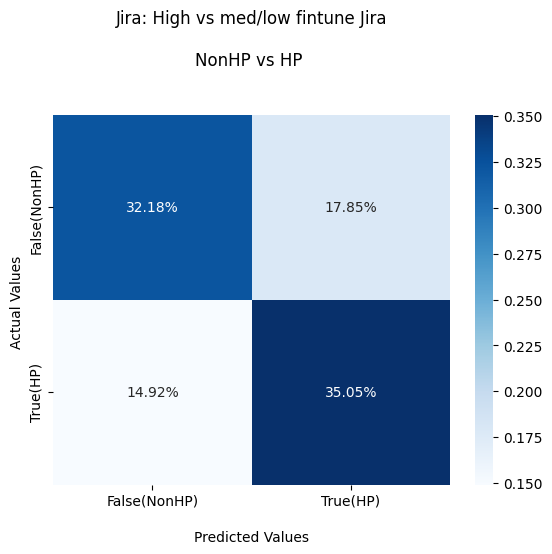

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title(f'Jira: High vs med/low fintune {project_name}\n\nNonHP vs HP \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonHP)','True(HP)'])
ax.yaxis.set_ticklabels(['False(NonHP)','True(HP)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [63]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.68      0.64      0.66      3268
           1       0.66      0.70      0.68      3265

    accuracy                           0.67      6533
   macro avg       0.67      0.67      0.67      6533
weighted avg       0.67      0.67      0.67      6533



In [64]:
test_df[["text","label","pred"]].to_csv(f"{project_name}_70_Test_inference.csv")

In [65]:
from sklearn.metrics import matthews_corrcoef

# Calculate the Matthew's Correlation Coefficient
mcc = matthews_corrcoef(test_df["label"].values, test_df["pred"].values)
print("Matthew's Correlation Coefficient:", mcc)

Matthew's Correlation Coefficient: 0.3451663951958049


In [66]:
tracker.stop()

0.0250426528993952